<a href="https://colab.research.google.com/github/AayushiWani/LY_Project_SLRSystem--KD_DL/blob/main/asl_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check what's available (everything should be pre-installed)
import torch  # Main deep learning framework; used for tensor operations and model building
import torchvision  # Contains datasets, model architectures, and transforms for images
from PIL import Image  # Opening and manipulating image files in Python
from torch.utils.data import Dataset, DataLoader, random_split  # Data utilities for creating custom datasets, batching, and splitting data
import os  # Interact with the operating system, e.g., file paths and directories
import torchvision.transforms as transforms  # Preprocessing and data augmentation for images
import torch.nn as nn  # Building neural network layers
import torch.nn.functional as F  # Functional operations like activations and loss functions
from torchvision.models import resnet50, ResNet50_Weights, mobilenet_v2, MobileNet_V2_Weights  # Import pre-trained model architectures and weights
import torch.optim as optim  # Optimization algorithms for training (SGD, Adam, etc.)
import zipfile  # For extracting ZIP archives, often needed for dataset handling
from tqdm import tqdm  # Progress bars for loops, helps track training/validation progress
from torch.cuda.amp import autocast, GradScaler  # Automatic Mixed Precision for faster training on GPU
from sklearn.metrics import confusion_matrix, classification_report  # Model evaluation tools for generating metrics and reports
import seaborn as sns  # Data visualization (e.g., heatmaps for confusion matrix)
import matplotlib.pyplot as plt  # Plotting graphs and charts
import numpy as np  # Numerical operations, matrix manipulations
import glob, shutil  # glob for pattern-based file searching; shutil for file/directory manipulation

print(f"✅ PyTorch: {torch.__version__}")  # Print installed PyTorch version for confirmation
print(f"✅ CUDA: {torch.cuda.is_available()}")  # Check CUDA (GPU) availability
print(f"✅ GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU only'}")  # Print GPU name or fallback to CPU
print("🎉 Ready to go!")  # Signal readiness to proceed


✅ PyTorch: 2.8.0+cu126
✅ CUDA: True
✅ GPU: Tesla T4
🎉 Ready to go!


In [ ]:
# Mount Google Drive so files (datasets, models, outputs) can be accessed directly from Colab
from google.colab import drive  # Import the drive module provided by Google Colab for file system integration

drive.mount('/content/drive')  # Mount Google Drive at the given path so you can read/write files as if they are local


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the path to your dataset in Google Drive

zip_file_path_1 = '/content/drive/MyDrive/Asl_alphabet.zip'  # Original ASL alphabet dataset (used for testing )
zip_file_path_2 = '/content/drive/MyDrive/ASL_alphabet_augmented.zip'  # Augmented dataset with additional variations to reduce overfitting (training dataset)
zip_file_path = '/content/drive/MyDrive/american-sign-language-letters-voc.zip'  # Another ASL dataset (70 training, 15 validation, 15 testing)

# Print paths to provide quick confirmation and debugging info, ensuring the mounted paths and naming are correct
print(f"Train zip file located at: {zip_file_path_2}")
print(f"Test zip file located at: {zip_file_path_1}")
print(f"Train zip file located at: {zip_file_path}")


Train zip file located at: /content/drive/MyDrive/ASL_alphabet_augmented.zip
Test zip file located at: /content/drive/MyDrive/Asl_alphabet.zip
Train zip file located at: /content/drive/MyDrive/american-sign-language-letters-voc.zip


In [ ]:
# Adding dataset to colab content path

# Define where you want to unzip the dataset
unzip_dir_1 = '/content/Asl_alphabet/'               # Destination for original ASL alphabet images
unzip_dir_2 = '/content/Asl_alphabet_augmented/'     # Destination for augmented dataset images

# Create unzip directory if it doesn't exist
if not os.path.exists(unzip_dir_1):                  # Check if the target folder exists
    os.makedirs(unzip_dir_1)                         # If not, create it

if not os.path.exists(unzip_dir_2):                  # Repeat for the augmented folder
    os.makedirs(unzip_dir_2)

print(f"Unzipping dataset from {zip_file_path_1} to {unzip_dir_1}...")

# Unzip the first file (original dataset)
with zipfile.ZipFile(zip_file_path_1, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir_1)                  # Extract all the contents to the destination directory

print(f"Test Dataset successfully unzipped to: {unzip_dir_1}")

print(f"Unzipping dataset from {zip_file_path_2} to {unzip_dir_2}...")

# Unzip the second file (augmented dataset)
with zipfile.ZipFile(zip_file_path_2, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir_2)

print(f"Train Dataset successfully unzipped to: {unzip_dir_2}")

unzip_dir = '/content/'                              # General destination directory for additional datasets

# Check if the zip file exists (for third dataset)
if os.path.exists(zip_file_path):                    # If the alternate dataset exists
    if not os.path.exists(unzip_dir):                # Make sure target directory exists
        os.makedirs(unzip_dir)

    # If not unzipped already, unzip the file
    if not any([filename.endswith(('.jpg', '.png', '.xml', '.csv')) for filename in os.listdir(unzip_dir)]):
        print(f"Unzipping {zip_file_path}...")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(unzip_dir)
        print("Unzipped successfully!")
    else:
        print("Files are already unzipped.")
else:
    print(f"Error: {zip_file_path} does not exist.")

# Optionally list the contents
print("Contents of the unzip directory:")
os.listdir(unzip_dir)


Unzipping dataset from /content/drive/MyDrive/Asl_alphabet.zip to /content/Asl_alphabet/...
Test Dataset successfully unzipped to: /content/Asl_alphabet/
Unzipping dataset from /content/drive/MyDrive/ASL_alphabet_augmented.zip to /content/Asl_alphabet_augmented/...
Train Dataset successfully unzipped to: /content/Asl_alphabet_augmented/
Unzipping /content/drive/MyDrive/american-sign-language-letters-voc.zip...
Unzipped successfully!
Contents of the unzip directory:


['.config',
 'drive',
 'Asl_alphabet',
 'Asl_alphabet_augmented',
 'voc',
 'sample_data']

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Checks if a CUDA-enabled GPU is available and sets the torch device accordingly.
# If yes, computations will be done on GPU, otherwise on CPU.

In [ ]:
# Generate list of class labels
classes = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
# Creates a list with all uppercase English letters, representing ASL alphabet signs ('A' to 'Z').

class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
# Builds a dictionary mapping each class label ('A', 'B', ..., 'Z') to its corresponding integer index.
# Useful for converting between label strings and numerical labels for training/validation.

In [ ]:
from PIL import Image  # Library for opening/manipulating images
import xml.etree.ElementTree as ET  # Used for parsing and reading XML files (often annotation files)

def crop_image_to_box(image_path, xml_path):
    img = Image.open(image_path).convert('RGB')
    tree = ET.parse(xml_path)
    root = tree.getroot()
    bndbox = root.find('.//bndbox')  # Make sure to use .// for any level

    # Check if bndbox and all required fields exist
    if bndbox is None or \
       bndbox.find('xmin') is None or bndbox.find('ymin') is None or \
       bndbox.find('xmax') is None or bndbox.find('ymax') is None:
        print(f"Warning: Missing bounding box info in {xml_path}. Skipping this image.")
        return None  # Option 1: Skip

    xmin = int(float(bndbox.find('xmin').text))
    ymin = int(float(bndbox.find('ymin').text))
    xmax = int(float(bndbox.find('xmax').text))
    ymax = int(float(bndbox.find('ymax').text))
    return img.crop((xmin, ymin, xmax, ymax))



In [ ]:
#preparing datatset with labels- for inputting to model
class VOCHandDataset(Dataset):  # Custom PyTorch Dataset for ASL hand gesture images annotated in VOC format
    def __init__(self, voc_dir, transform=None):
        self.samples = []  # List to store image paths, annotation paths, and labels
        self.transform = transform  # Hold the transformation logic (often for preprocessing/augmentation)
        for fname in os.listdir(voc_dir):  # Iterate over all files in the dataset directory
            if fname.endswith('.jpg'):  # Only process image files
                label = fname[0].upper()  # The label is determined by the first letter of the filename (e.g., 'Axxxx.jpg')
                if label in class_to_idx:  # Make sure the label is valid (between 'A' and 'Z')
                    img_path = os.path.join(voc_dir, fname)  # Build the complete image file path
                    xml_path = img_path.replace('.jpg', '.xml')  # Find corresponding XML annotation
                    self.samples.append((img_path, xml_path, label))  # Store tuple of image, annotation, and label

    def __getitem__(self, idx):  # Enable batched data access via DataLoader
        img_path, xml_path, label = self.samples[idx]  # Get sample at index
        img = crop_image_to_box(img_path, xml_path)  # Crop image to bounding box using the earlier function
        if self.transform:
            img = self.transform(img)  # Apply preprocessing/augmentation if needed
        return img, class_to_idx[label]  # Return processed image and its numeric label

    def __len__(self):  # Define length for DataLoader batching
        return len(self.samples)  # Number of samples available


NameError: name 'Dataset' is not defined

In [ ]:
class ASLAlphabetDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.samples = []
        self.transform = transform
        for class_folder in os.listdir(base_dir):
            label = class_folder.upper()
            if label not in class_to_idx:
                continue
            folder_path = os.path.join(base_dir, class_folder)
            if not os.path.isdir(folder_path):
                continue
            for fname in os.listdir(folder_path):
                if fname.endswith('.jpg'):
                    img_path = os.path.join(folder_path, fname)
                    self.samples.append((img_path, label))
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, class_to_idx[label]
    def __len__(self):
        return len(self.samples)


In [ ]:
class ASLTestFlatDataset(Dataset):  # Custom PyTorch Dataset for "flat" ASL test images (no subfolders), labelled by filename
    def __init__(self, base_dir, transform=None):
        self.samples = []  # List to store (image path, label)
        self.transform = transform  # Hold preprocessing/augmentation logic

        for fname in os.listdir(base_dir):  # Iterate over all files in the base directory
            if fname.endswith('.jpg'):  # Only consider image files
                label = fname[0].upper()  # Use the first character of the filename as the class label ('A' from 'A_test.jpg')
                if label not in class_to_idx:  # Skip files with unrecognized labels
                    continue
                img_path = os.path.join(base_dir, fname)  # Full file path
                self.samples.append((img_path, label))  # Store the image path and label

    def __getitem__(self, idx):  # Access a specific item by index (for DataLoader)
        img_path, label = self.samples[idx]  # Get image path and label for this index
        img = Image.open(img_path).convert('RGB')  # Open and convert the image to RGB
        if self.transform:
            img = self.transform(img)  # Apply transforms if provided
        return img, class_to_idx[label]  # Return transformed image and its index label

    def __len__(self):  # Report dataset size
        return len(self.samples)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 pixels (standard input size for many pretrained models)
    transforms.ToTensor(),          # Convert the image (PIL or numpy) into a scaled PyTorch tensor (channels first, values in [0,1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize tensor channel-wise (match ImageNet pre-trained expectations)
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# Load datasets
voc_dir = '/content/voc/'  # update as necessary
asl_train_dir = '/content/Asl_alphabet_augmented/'
asl_test_dir = '/content/Asl_alphabet/asl_alphabet_test'

voc_dataset = VOCHandDataset(voc_dir, transform=transform)
asl_train_dataset = ASLAlphabetDataset(asl_train_dir, transform=transform)
asl_test_dataset = ASLTestFlatDataset(asl_test_dir, transform=transform)

# Split VOC into train/val
voc_len = len(voc_dataset)
voc_train_len = int(0.7 * voc_len)
voc_val_len = int(0.15 * voc_len)
voc_test_len = voc_len - voc_train_len - voc_val_len

voc_train, voc_val, voc_test = random_split(
    voc_dataset, [voc_train_len, voc_val_len, voc_test_len],
    generator=torch.Generator().manual_seed(42)
)

# Combine for final
final_train = torch.utils.data.ConcatDataset([asl_train_dataset, voc_train])
final_val = torch.utils.data.ConcatDataset([voc_val])
final_test = torch.utils.data.ConcatDataset([asl_test_dataset, voc_test])

# DataLoaders
train_loader = DataLoader(final_train, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(final_val, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(final_test, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
class ResNet50Teacher(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)  # Load a pretrained ResNet50
        in_features = self.backbone.fc.in_features  # Get the number of input features to the last layer
        self.backbone.fc = nn.Linear(in_features, num_classes)  # Replace last FC layer with one for 26 classes

    def forward(self, x):
        return self.backbone(x)  # Forward call sends data through the full model

class MobileNetV2Student(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()
        self.backbone = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)  # Pretrained MobileNetV2
        self.backbone.classifier = nn.Sequential(  # Redefine the classification head
            nn.Dropout(0.2),
            nn.Linear(self.backbone.last_channel, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)  # Forward pass

NUM_CLASSES = 26
teacher_model = ResNet50Teacher(num_classes=NUM_CLASSES).to(device)  # Instantiate and move to device (CPU/GPU)
student_model = MobileNetV2Student(num_classes=NUM_CLASSES).to(device)

print(f"✅ Teacher params: {sum(p.numel() for p in teacher_model.parameters())}")
print(f"✅ Student params: {sum(p.numel() for p in student_model.parameters())}")


✅ Teacher params: 23561306
✅ Student params: 2257178


In [ ]:
def train_teacher(model, train_loader, val_loader, num_epochs=5, lr=0.001, save_dir="checkpoints"):
    os.makedirs(save_dir, exist_ok=True)  # Create directory to save models if it doesn't exist

    criterion = nn.CrossEntropyLoss()  # Loss function for classification: compares logits to true labels
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # Adam optimizer with learning rate and regularization
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2) #optimiser - reduces the lr, schedular- tells when to  reduce
    # Scheduler reduces learning rate when validation accuracy stops improving (helps better convergence)

    best_val_acc = 0  # best accuracy out of all epochs
    scaler = torch.cuda.amp.GradScaler()  # Enables mixed-precision training for performance on GPU

    for epoch in range(1, num_epochs + 1):
        model.train()  # Set model to training mode (activates dropout, batchnorm, etc.)
        running_loss = 0.0  # Cumulative loss for this epoch
        running_correct = 0  # Total correct predictions
        running_total = 0  # Total samples processed

        loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}")  # Progress bar

        for batch_i, (images, labels) in loop:  # Iterate through each batch
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            optimizer.zero_grad()  # Reset gradients for this iteration

            with torch.cuda.amp.autocast():  # Perform calculations in mixed precision
                outputs = model(images)  # Forward pass: model produces prediction scores
                loss = criterion(outputs, labels)  # Compute loss between predictions and true labels

            scaler.scale(loss).backward()  # Compute gradients (backpropagation)
            scaler.step(optimizer)  # Update model weights using optimizer
            scaler.update()  # Prepare scaler for next iteration (mixed precision housekeeping)

            _, preds = torch.max(outputs, 1)  # Get predicted class indices from model scores
            running_loss += loss.item() * labels.size(0)  # Accumulate loss weighted by batch size
            running_correct += (preds == labels).sum().item()  # Accumulate count of correct predictions
            running_total += labels.size(0)  # Accumulate sample count

            loop.set_postfix(loss=loss.item(), acc=(running_correct / running_total) * 100)  # Update progress bar

        train_loss = running_loss / running_total  # Average loss per sample
        train_acc = running_correct / running_total * 100  # Training accuracy as percentage

        val_acc = evaluate(model, val_loader)  # Run model evaluation on validation set
        print(f"Epoch {epoch} Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        scheduler.step(val_acc)  # Update learning rate scheduler based on validation accuracy

        if val_acc > best_val_acc:  # If best accuracy so far, save model checkpoint
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(save_dir, f"teacher_epoch{epoch}_acc{val_acc:.2f}.pth"))
            print("Saved best teacher model checkpoint")

    print(f"Best validation accuracy: {best_val_acc:.2f}%")

    # After all epochs, copy best checkpoint to master filename
    ckpt_files = glob.glob(os.path.join(save_dir, "teacher_epoch*_acc*.pth"))
    if ckpt_files:
        best_ckpt = sorted(ckpt_files, key=lambda x: float(x.split("acc")[1].split(".pth")[0]), reverse=True)[0]
        shutil.copy(best_ckpt, os.path.join(save_dir, "teacher_best_aug.pth"))
        print(f"Best checkpoint copied to {os.path.join(save_dir, 'teacher_best_aug.pth')}")


In [ ]:
class DistillationLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.5):
        super().__init__()
        self.temperature = temperature           # Controls softening of probabilistic outputs
        self.alpha = alpha                       # Balance between hard and soft label losses
        self.ce = nn.CrossEntropyLoss()          # Standard cross-entropy for hard labels
        self.kl = nn.KLDivLoss(reduction='batchmean')  # Kullback–Leibler divergence for soft labels

    def forward(self, student_logits, teacher_logits, true_labels):
        T = self.temperature
        p_teacher = F.softmax(teacher_logits / T, dim=1)      # Soft probabilities from teacher (divided by temperature)
        p_student = F.log_softmax(student_logits / T, dim=1)  # Log-softened probabilities from student
        kd_loss = self.kl(p_student, p_teacher) * (T * T)     # KL loss (knowledge distillation), weighted by temperature^2
        ce_loss = self.ce(student_logits, true_labels)         # Standard classification loss (hard label)
        return self.alpha * ce_loss + (1 - self.alpha) * kd_loss  # Weighted sum: overall distillation loss


In [ ]:
def train_student_with_distillation(teacher, student, train_loader, val_loader, num_epochs=5, lr=0.001,
                                   alpha=0.5, temperature=4.0, save_dir="checkpoints"):
    os.makedirs(save_dir, exist_ok=True)  # Ensure save directory exists

    teacher.eval()  # Set teacher to evaluation mode (turns off dropout/batchnorm learning)
    criterion = DistillationLoss(temperature=temperature, alpha=alpha)  # Custom loss (see Cell 15)
    optimizer = optim.Adam(student.parameters(), lr=lr, weight_decay=1e-5)  # Adam optimizer for student
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)  # LR scheduler

    best_val_acc = 0
    scaler = torch.cuda.amp.GradScaler()  # Enable mixed-precision training

    for epoch in range(1, num_epochs + 1):
        student.train()  # Student is trained, teacher always in eval mode

        running_loss = 0.0
        running_correct = 0
        running_total = 0

        loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}")
        for batch_i, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(images)  # Get teacher's output, don't compute gradients for teacher!

            with torch.cuda.amp.autocast():
                student_logits = student(images)  # Student's output
                loss = criterion(student_logits, teacher_logits, labels)  # Compute distillation loss

            scaler.scale(loss).backward()  # Backpropagate using scaled loss
            scaler.step(optimizer)  # Update student weights
            scaler.update()

            _, preds = torch.max(student_logits, 1)
            running_loss += loss.item() * labels.size(0)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=(running_correct / running_total) * 100)

        train_loss = running_loss / running_total
        train_acc = running_correct / running_total * 100

        val_acc = evaluate(student, val_loader)
        print(f"Epoch {epoch} Student Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), os.path.join(save_dir, f"student_epoch{epoch}_acc{val_acc:.2f}.pth"))
            print("Saved best student model checkpoint")

    print(f"Best validation accuracy: {best_val_acc:.2f}%")

    ckpt_files = glob.glob(os.path.join(save_dir, "student_epoch*_acc*.pth"))
    if ckpt_files:
        best_ckpt = sorted(ckpt_files, key=lambda x: float(x.split("acc")[1].split(".pth")[0]), reverse=True)[0]
        shutil.copy(best_ckpt, os.path.join(save_dir, "student_best_aug.pth"))
        print(f"Best checkpoint copied to {os.path.join(save_dir, 'student_best_aug.pth')}")


In [ ]:
def evaluate(model, test_loader):
    model = model.to(device)   # Move model to designated device (GPU/CPU)
    model.eval()               # Set model to evaluation mode (disable dropout, batchnorm updates)
    correct = 0                # Counter for correct predictions
    total = 0                  # Counter for total samples tested

    with torch.no_grad():      # No gradients needed for evaluation, saves memory & speeds up computation
        for images, labels in test_loader:           # Iterate over batches in test_loader
            images, labels = images.to(device), labels.to(device)  # Move images & labels to device
            outputs = model(images)                  # Model outputs predicted class scores (logits)
            _, predicted = torch.max(outputs, 1)     # Find the class index with highest score (the prediction)
            total += labels.size(0)                  # Add number of samples in this batch to total
            correct += (predicted == labels).sum().item()  # Increment correct for each match

    if total == 0:
        print("🟥 No samples found in test_loader. Check your test set.")
        return 0.0

    acc = correct / total * 100   # Calculate accuracy as percentage
    return acc


In [ ]:
def evaluate_with_confusion(model, loader):
    model.eval()                          # Set model to evaluation mode (turn off dropout, batchnorm statistics)
    y_true = []                           # List to accumulate true class labels for all samples
    y_pred = []                           # List to accumulate model predictions

    with torch.no_grad():                 # Disable gradient computations for efficiency/speed
        for images, labels in loader:     # Loop through batches in the data loader
            images, labels = images.to(device), labels.to(device)  # Move tensors to correct device (GPU/CPU)
            outputs = model(images)                     # Get predicted logits for each sample
            _, predicted = torch.max(outputs, 1)        # Convert logits to predicted class index per sample
            y_true.extend(labels.cpu().numpy())         # Add batch's true labels to y_true
            y_pred.extend(predicted.cpu().numpy())      # Add batch's predicted labels to y_pred

    labels = list(range(len(classes)))                  # Create list of all possible label indices
    print(classification_report(y_true, y_pred, labels=labels, target_names=classes))   # Print precision, recall, F1, support

    cm = confusion_matrix(y_true, y_pred, labels=labels)                        # Create confusion matrix for label pairs
    plt.figure(figsize=(12, 10))                                                # Set figure size for plot
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")   # Draw heatmap
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')                                               # Label and title the plot
    plt.show()                                                                 # Display the plot


In [ ]:
# ========== CELL 19: Load the best checkpoint from available saved models ==========

def load_best_checkpoint(model, checkpoint_dir, prefix):
    # List all files in the checkpoint directory with the given prefix and containing 'acc'
    files = [f for f in os.listdir(checkpoint_dir) if f.startswith(prefix) and "acc" in f]

    # If there are no matching files, raise an error to help with debugging and safety
    if not files:
        raise FileNotFoundError(
            f"No checkpoint files starting with '{prefix}' and containing 'acc' found in {checkpoint_dir}"
        )

    # Sort the checkpoint files by the validation accuracy value embedded in the filename (highest first)
    # Example filename format: teacher_epoch3_acc94.00.pth
    best_file = sorted(
        files,
        key=lambda x: float(x.split("acc")[1].split(".")[0]),  # Extract accuracy as a float from filename
        reverse=True
    )[0]  # Select the file with the highest accuracy

    # Print which checkpoint is about to be loaded (transparency and debugging)
    print(f"Loading checkpoint {best_file}")

    # Load model weights from the checkpoint file into the model architecture
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, best_file)))

    # Return the model now holding the best weights
    return model




In [ ]:
# ========== CELL 20: Set up persistent save directory on Google Drive ==========

SAVE_DIR = "/content/drive/MyDrive/asl_checkpoints/"  # Path in Google Drive to store/save checkpoints

# Ensure the save directory exists (do nothing if it already exists, so it's always safe to run)
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
train_teacher(teacher_model, train_loader, val_loader, num_epochs=10, lr=1e-3, save_dir=SAVE_DIR)
train_student_with_distillation(teacher_model, student_model, train_loader, val_loader, num_epochs=10, lr=1e-3, save_dir=SAVE_DIR)


/tmp/ipython-input-1590983061.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enables mixed-precision training for performance on GPU
Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipython-input-1590983061.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Perform calculations in mixed precision
Epoch 1/10: 100%|██████████| 38/38 [00:10<00:00,  3.47it/s, acc=48.6, loss=0.431]


Epoch 1 Train Loss: 1.8772, Train Acc: 48.64%, Val Acc: 54.05%
Saved best teacher model checkpoint


Epoch 2/10: 100%|██████████| 38/38 [00:06<00:00,  6.12it/s, acc=85.1, loss=0.485]


Epoch 2 Train Loss: 0.5201, Train Acc: 85.11%, Val Acc: 73.36%
Saved best teacher model checkpoint


Epoch 3/10: 100%|██████████| 38/38 [00:06<00:00,  6.25it/s, acc=91.3, loss=0.371]


Epoch 3 Train Loss: 0.2934, Train Acc: 91.32%, Val Acc: 81.47%
Saved best teacher model checkpoint


Epoch 4/10: 100%|██████████| 38/38 [00:06<00:00,  5.54it/s, acc=96.2, loss=0.0795]


Epoch 4 Train Loss: 0.1340, Train Acc: 96.20%, Val Acc: 84.17%
Saved best teacher model checkpoint


Epoch 5/10: 100%|██████████| 38/38 [00:06<00:00,  6.32it/s, acc=97, loss=0.0374]


Epoch 5 Train Loss: 0.1072, Train Acc: 97.02%, Val Acc: 91.89%
Saved best teacher model checkpoint


Epoch 6/10: 100%|██████████| 38/38 [00:06<00:00,  5.47it/s, acc=98.6, loss=0.174]


Epoch 6 Train Loss: 0.0542, Train Acc: 98.59%, Val Acc: 96.14%
Saved best teacher model checkpoint


Epoch 7/10: 100%|██████████| 38/38 [00:05<00:00,  6.36it/s, acc=99.2, loss=0.0307]


Epoch 7 Train Loss: 0.0373, Train Acc: 99.17%, Val Acc: 92.28%


Epoch 8/10: 100%|██████████| 38/38 [00:08<00:00,  4.56it/s, acc=97.4, loss=0.147]


Epoch 8 Train Loss: 0.1008, Train Acc: 97.44%, Val Acc: 90.73%


Epoch 9/10: 100%|██████████| 38/38 [00:06<00:00,  5.78it/s, acc=96.6, loss=0.199]


Epoch 9 Train Loss: 0.1180, Train Acc: 96.61%, Val Acc: 85.33%


Epoch 10/10: 100%|██████████| 38/38 [00:05<00:00,  6.48it/s, acc=98.5, loss=0.119]


Epoch 10 Train Loss: 0.0575, Train Acc: 98.51%, Val Acc: 96.53%
Saved best teacher model checkpoint
Best validation accuracy: 96.53%
Best checkpoint copied to /content/drive/MyDrive/asl_checkpoints/teacher_best_aug.pth


/tmp/ipython-input-3925927416.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable mixed-precision training
Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipython-input-3925927416.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, acc=42.3, loss=3.74]


Epoch 1 Student Train Loss: 9.4489, Train Acc: 42.27%, Val Acc: 72.59%
Saved best student model checkpoint


Epoch 2/10: 100%|██████████| 38/38 [00:06<00:00,  5.51it/s, acc=86.4, loss=1.3]


Epoch 2 Student Train Loss: 2.4511, Train Acc: 86.44%, Val Acc: 88.80%
Saved best student model checkpoint


Epoch 3/10: 100%|██████████| 38/38 [00:06<00:00,  5.47it/s, acc=95.1, loss=1.56]


Epoch 3 Student Train Loss: 1.1121, Train Acc: 95.12%, Val Acc: 91.89%
Saved best student model checkpoint


Epoch 4/10: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s, acc=97.7, loss=1.17]


Epoch 4 Student Train Loss: 0.7670, Train Acc: 97.68%, Val Acc: 98.07%
Saved best student model checkpoint


Epoch 5/10: 100%|██████████| 38/38 [00:06<00:00,  5.69it/s, acc=99.4, loss=0.594]


Epoch 5 Student Train Loss: 0.5739, Train Acc: 99.42%, Val Acc: 97.68%


Epoch 6/10: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s, acc=98.7, loss=0.438]


Epoch 6 Student Train Loss: 0.5197, Train Acc: 98.68%, Val Acc: 98.84%
Saved best student model checkpoint


Epoch 7/10: 100%|██████████| 38/38 [00:06<00:00,  5.64it/s, acc=99.5, loss=0.434]


Epoch 7 Student Train Loss: 0.4356, Train Acc: 99.50%, Val Acc: 98.84%


Epoch 8/10: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s, acc=99.6, loss=0.449]


Epoch 8 Student Train Loss: 0.3754, Train Acc: 99.59%, Val Acc: 98.46%


Epoch 9/10: 100%|██████████| 38/38 [00:06<00:00,  5.60it/s, acc=99.9, loss=0.428]


Epoch 9 Student Train Loss: 0.3373, Train Acc: 99.92%, Val Acc: 98.46%


Epoch 10/10: 100%|██████████| 38/38 [00:06<00:00,  5.49it/s, acc=99.9, loss=0.318]


Epoch 10 Student Train Loss: 0.2896, Train Acc: 99.92%, Val Acc: 98.84%
Best validation accuracy: 98.84%
Best checkpoint copied to /content/drive/MyDrive/asl_checkpoints/student_best_aug.pth


In [ ]:
print("Files in checkpoint dir:", os.listdir(SAVE_DIR))

Files in checkpoint dir: ['teacher_epoch1_acc70.23.pth', 'teacher_epoch2_acc86.42.pth', 'teacher_epoch3_acc93.35.pth', 'teacher_epoch7_acc97.98.pth', 'teacher_epoch9_acc98.27.pth', 'teacher_best_aug.pth', 'student_epoch1_acc71.97.pth', 'student_epoch2_acc91.33.pth', 'student_epoch3_acc97.11.pth', 'student_epoch5_acc97.98.pth', 'student_epoch6_acc98.27.pth', 'student_epoch7_acc98.84.pth', 'teacher_epoch1_acc59.46.pth', 'teacher_epoch2_acc76.06.pth', 'teacher_epoch3_acc83.78.pth', 'teacher_epoch4_acc86.49.pth', 'teacher_epoch5_acc94.21.pth', 'teacher_epoch9_acc96.53.pth', 'teacher_epoch10_acc98.07.pth', 'student_epoch1_acc59.07.pth', 'student_epoch2_acc89.19.pth', 'student_epoch3_acc94.21.pth', 'student_epoch4_acc96.91.pth', 'student_epoch5_acc97.68.pth', 'student_epoch7_acc99.23.pth', 'student_epoch9_acc99.61.pth', 'student_best_aug.pth', 'teacher_epoch1_acc54.05.pth', 'teacher_epoch2_acc73.36.pth', 'teacher_epoch3_acc81.47.pth', 'teacher_epoch4_acc84.17.pth', 'teacher_epoch5_acc91.89.p

In [ ]:

teacher_model = load_best_checkpoint(teacher_model, SAVE_DIR, "teacher")
student_model = load_best_checkpoint(student_model, SAVE_DIR, "student")

print(f"Teacher Test Accuracy: {evaluate(teacher_model, test_loader):.2f}%")
print(f"Student Test Accuracy: {evaluate(student_model, test_loader):.2f}%")


Loading checkpoint teacher_epoch9_acc98.27.pth
Loading checkpoint student_epoch7_acc99.23.pth
Teacher Test Accuracy: 99.23%
Student Test Accuracy: 99.23%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       1.00      1.00      1.00         6
           C       1.00      1.00      1.00        10
           D       1.00      1.00      1.00        12
           E       1.00      1.00      1.00        10
           F       1.00      1.00      1.00         5
           G       1.00      1.00      1.00        12
           H       1.00      1.00      1.00        11
           I       1.00      1.00      1.00        11
           J       1.00      1.00      1.00         7
           K       1.00      1.00      1.00         6
           L       1.00      1.00      1.00        15
           M       1.00      0.92      0.96        13
           N       1.00      1.00      1.00         8
           O       1.00      1.00      1.00        12
           P       1.00      0.92      0.96        12
           Q       0.93      1.00      0.97        14
           R       1.00    

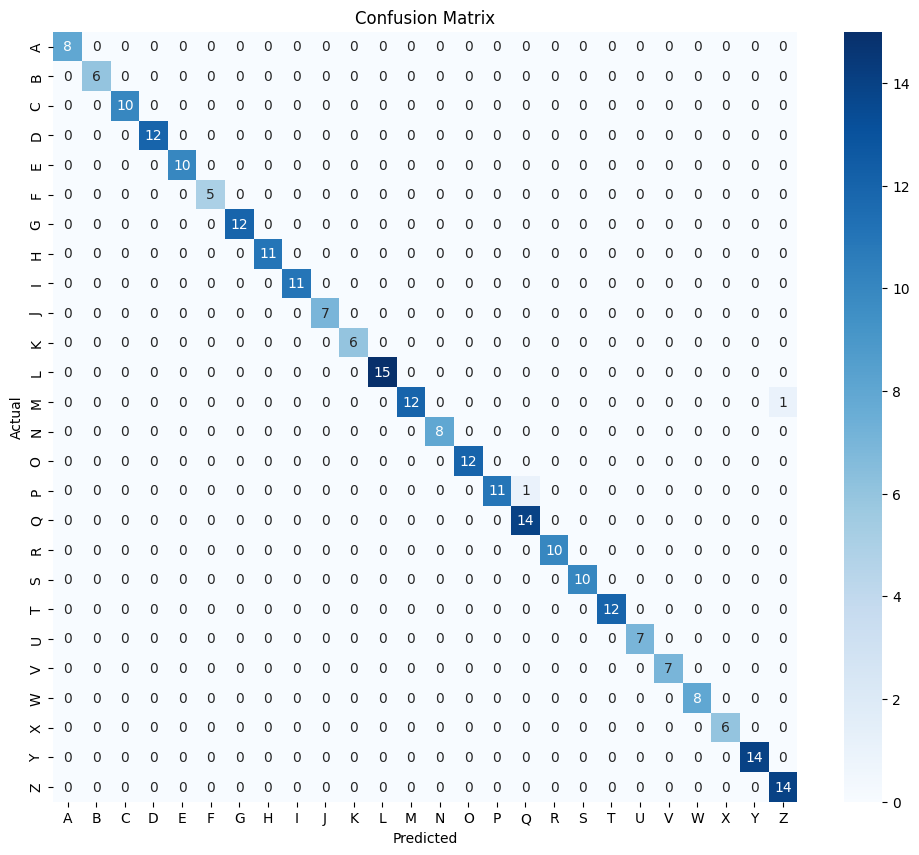

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       1.00      1.00      1.00         6
           C       1.00      1.00      1.00        10
           D       1.00      1.00      1.00        12
           E       1.00      1.00      1.00        10
           F       1.00      1.00      1.00         5
           G       1.00      1.00      1.00        12
           H       1.00      1.00      1.00        11
           I       1.00      1.00      1.00        11
           J       1.00      1.00      1.00         7
           K       1.00      1.00      1.00         6
           L       1.00      1.00      1.00        15
           M       0.93      1.00      0.96        13
           N       1.00      0.75      0.86         8
           O       1.00      1.00      1.00        12
           P       1.00      1.00      1.00        12
           Q       1.00      1.00      1.00        14
           R       1.00    

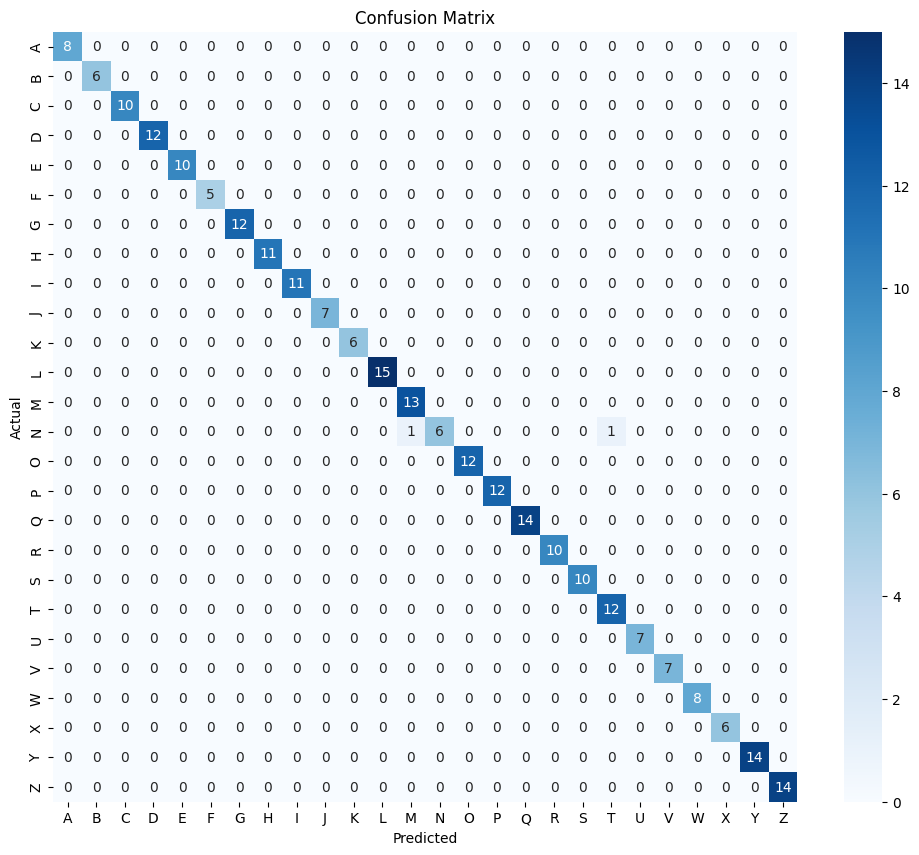

In [ ]:
evaluate_with_confusion(teacher_model, test_loader)
evaluate_with_confusion(student_model, test_loader)
